# Examine Results

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom_test, chi2_contingency, pearsonr, spearmanr
import seaborn as sns

from convnwb.paths import Paths
from convnwb.io import get_files, load_json, load_jsons_to_df, load_matfile

from spiketools.plts.data import plot_hist, plot_bar
from spiketools.plts.utils import make_axes
from spiketools.plts.annotate import add_hlines

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Set pandas display options
pd.options.display.max_columns = None

## Settings

In [4]:
# Set which experiment version to run
experiment = 'THF'

In [5]:
# Define list of analyses
analyses = ['chest', 'full', 'empty',
            #'place',
            'target',
            'sp']

# Collect names of analysis columns
analysis_columns = ['is_' + analysis + '_cell' for analysis in analyses]

In [6]:
# Set the folder to load results from
data_path = '../results/units/' + experiment

## Check Files

In [7]:
# Get the list of files
res_files = get_files(data_path, select='session')

In [8]:
# # Drop a specific set of files
# res_files = [file for file in res_files if 'wv003' not in file]

In [9]:
# # Select a specific set of files
# res_files = [file for file in res_files if 'wv001' in file]

In [10]:
# Check the number of available files
n_files = len(res_files)
n_files

643

## Load Example File

In [11]:
# Load an example file
file = res_files[0]
data = load_json(file, folder=str(data_path))

In [12]:
# # Check example file
# data

## Collect Results

In [13]:
# Collect all unit results together into a dataframe
all_results = load_jsons_to_df(res_files, folder=data_path)

In [14]:
# # Clean up some datatypes - cast integers
# set_ints = ['uid', 'wvID', 'keep', 'cluster', 'n_spikes']
# all_results[set_ints] = all_results[set_ints].astype('int')

In [15]:
# Check the columns
all_results.columns

Index(['uid', 'session_id', 'subject_id', 'wvID', 'keep', 'n_spikes',
       'firing_rate', 'cluster', 'channel', 'location', 'fr_t_val_all',
       'fr_p_val_all', 'fr_t_val_empt', 'fr_p_val_empt', 'fr_t_val_full',
       'fr_p_val_full', 'target_anova', 'serial_anova',
       'target_anova_surr_p_val', 'target_anova_surr_z_score',
       'serial_anova_surr_p_val', 'serial_anova_surr_z_score'],
      dtype='object')

In [16]:
# Check the head of the results
all_results.head()

,uid,session_id,subject_id,wvID,keep,n_spikes,firing_rate,cluster,channel,location,fr_t_val_all,fr_p_val_all,fr_t_val_empt,fr_p_val_empt,fr_t_val_full,fr_p_val_full,target_anova,serial_anova,target_anova_surr_p_val,target_anova_surr_z_score,serial_anova_surr_p_val,serial_anova_surr_z_score
0,0,THF_wv001_session_0,wv001,1,True,630,0.520936,2229,A10,LAH,0.838964,0.405121,-1.156732,0.261719,1.310645,0.198513,1.591088,0.966072,0.149,0.973302,0.395,-0.024754
1,1,THF_wv001_session_0,wv001,2,True,454,0.371356,2360,A10,LAH,0.747516,0.457936,-1.071432,0.297397,2.223143,0.032760,0.931677,1.034851,0.464,-0.183516,0.383,0.031135
2,2,THF_wv001_session_0,wv001,3,True,580,0.468688,2421,A10,LAH,0.659236,0.512495,0.281954,0.781027,0.680864,0.500437,0.810753,1.183255,0.526,-0.262694,0.196,0.562684
3,3,THF_wv001_session_0,wv001,4,True,2164,1.734822,2556,A10,LAH,-0.051453,0.959151,1.046558,0.308436,-0.739510,0.464529,2.017667,1.482066,0.061,1.680190,0.166,0.635558
4,4,THF_wv001_session_0,wv001,5,True,342,0.276226,774,A15,LAH,-0.850696,0.398627,-0.842344,0.410074,-0.320374,0.750590,0.974146,0.667268,0.377,-0.051683,0.530,-0.298415


### Unit Checks

In [17]:
# Firing rate threshold checks
print('# neurons fr < 0.15: \t', sum(all_results.firing_rate < 0.15))
print('# neurons fr < 0.50: \t', sum(all_results.firing_rate < 0.50))

# neurons fr < 0.15: 	 40
# neurons fr < 0.50: 	 225


In [18]:
# # Plot the distribution of firing rates
# plot_hist(all_results['firing_rate'].values)

In [19]:
# Add a marker for firing rate threshold in the TH experiment
all_results['keep_th'] = (all_results['firing_rate'] < 0.15).values

In [20]:
# #
# all_results = all_results[all_results.firing_rate > 0.15]

In [21]:
# Check number of neurons
n_units = len(all_results)
print('# neurons: ', n_units)

# neurons:  643


### Location Checks

In [22]:
# Check the set of sampled locations
locations = set(all_results['location'])
locations

{'LA', 'LAH', 'LPH', 'RA', 'RAH', 'RPH'}

In [23]:
# Check location counts
all_results['location'].value_counts()

LA     229
LPH    118
LAH    112
RA     103
RAH     56
RPH     25
Name: location, dtype: int64

<AxesSubplot:>

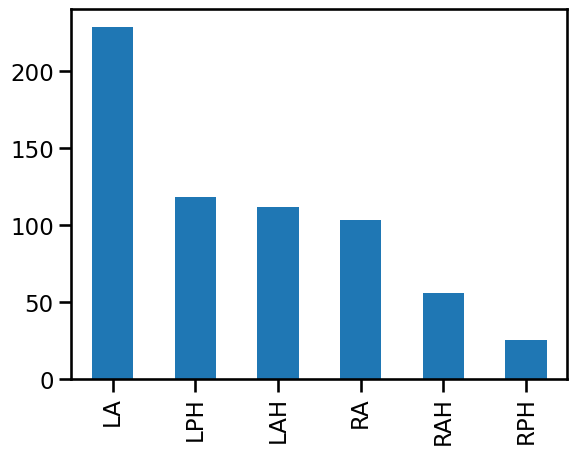

In [24]:
# Plot the counts per location
all_results['location'].value_counts().plot(kind='bar')

In [25]:
# Define location map
locmap = {'LA' : 'AMY',
          'RA' : 'AMY',
          'LAH' : 'AH',
          'RAH' : 'AH',
          'LPH' : 'PH',
          'RPH' : 'PH'}

In [26]:
# Set and collect which area each unit it is
all_results['region'] = all_results['location'].map(locmap)

In [27]:
# Check area counts
all_results['region'].value_counts()

AMY    332
AH     168
PH     143
Name: region, dtype: int64

<AxesSubplot:>

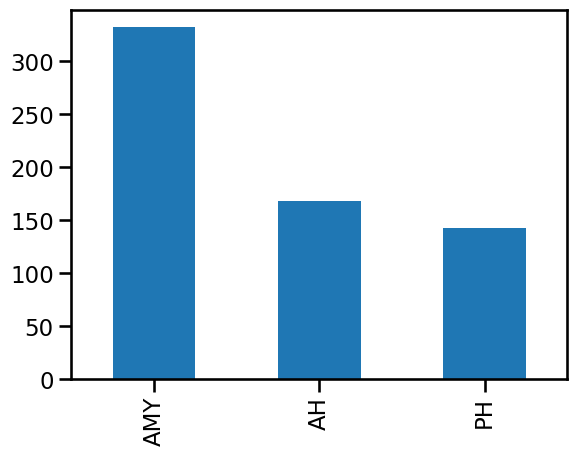

In [28]:
# Plot the counts per area
all_results['region'].value_counts().plot(kind='bar')

In [29]:
# Check the set of sampled areas
regions = set(all_results['region'])
regions

{'AH', 'AMY', 'PH'}

### Binary labels

In [30]:
# Set significance level
ALPHA_LEVEL = 0.05

In [31]:
# Add binary labels for statistical tests
all_results['is_chest_cell'] = all_results['fr_p_val_all'] < ALPHA_LEVEL
all_results['is_full_cell'] = all_results['fr_p_val_full'] < ALPHA_LEVEL
all_results['is_empty_cell'] = all_results['fr_p_val_empt'] < ALPHA_LEVEL
#all_results['is_place_cell'] = all_results['place_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_target_cell'] = all_results['target_anova_surr_p_val'] < ALPHA_LEVEL
all_results['is_sp_cell'] = all_results['serial_anova_surr_p_val'] < ALPHA_LEVEL

In [32]:
# all_results['is_place_cell'] = all_results['place_info_surr_p_val'] < ALPHA_LEVEL
# all_results['is_target_cell'] = all_results['target_info_surr_p_val'] < ALPHA_LEVEL

### Check numbers

In [33]:
# Check the total number of cells
print('Total number of cells: {}'.format(n_files))

Total number of cells: 643


## Check Results

In [34]:
# Get total number of units
n_units = len(all_results)

In [35]:
# Collect numbers of significant cells
results = {}
for analysis in analyses:
    results[analysis] = sum(all_results['is_' + analysis + '_cell'])

In [36]:
# Compute significance of the counts of detected neurons
stats = {}
for analysis in analyses:
    stats[analysis] = binom_test(results[analysis], n_units, ALPHA_LEVEL)

In [37]:
# Check the number & percent of significant cells per analysis
print('{} - total cells: {}\n'.format(experiment, n_units))
for analysis in analyses:
    print('# {} cells:     \t\t{:3d}  ({:5.2f}%) \t\t {:.4f}'.format(\
        analysis, results[analysis], results[analysis] / n_units * 100, stats[analysis]))

THF - total cells: 643

# chest cells:     		 82  (12.75%) 		 0.0000
# full cells:     		108  (16.80%) 		 0.0000
# empty cells:     		 42  ( 6.53%) 		 0.0846
# target cells:     		 43  ( 6.69%) 		 0.0567
# sp cells:     		121  (18.82%) 		 0.0000


## Save out results

In [38]:
# Save out of CSV
#all_results.to_csv(experiment + '_all_results.csv')

In [39]:
# # TEMP - SAVE DF
# all_results.to_csv(experiment + '_all_results_nov3.csv')

## Check Results by Subject / Session

In [40]:
# Check the number of detected cells per subject
pd.pivot_table(all_results, analysis_columns, index='subject_id', aggfunc=np.sum)

,is_chest_cell,is_empty_cell,is_full_cell,is_sp_cell,is_target_cell
subject_id,,,,,
wv001,33,12,47,45,20
wv002,11,8,16,28,6
wv003,3,0,5,1,1
wv004,34,20,40,43,14
wv005,1,2,0,4,2


In [41]:
# Check the number of detected cells per session
pd.pivot_table(all_results, analysis_columns, index=['subject_id', 'session_id'], aggfunc=np.sum)

is_chest_cell  is_empty_cell  is_full_cell  \
subject_id session_id                                                        
wv001      THF_wv001_session_0              5              3            15   
           THF_wv001_session_2              9              3            12   
           THF_wv001_session_3             11              2            12   
           THF_wv001_session_4              8              4             8   
wv002      THF_wv002_session_0              7              5            13   
           THF_wv002_session_1              4              3             3   
wv003      THF_wv003_session_0              3              0             5   
wv004      THF_wv004_session_0             24             14            26   
           THF_wv004_session_1             10              6            14   
wv005      THF_wv005_session_0              1              2             0   

                                is_sp_cell  is_target_cell  
subject_id session_id                                       
wv001      THF_wv001_session_0           5              11  
           THF_wv001_session_2           7               2  
           THF_wv001_session_3          17               5  
           THF_wv001_session_4          16               2  
wv002      THF_wv002_session_0          13               3  
           THF_wv002_session_1          15               3  
wv003      THF_wv003_session_0           1               1  
wv004      THF_wv004_session_0          17               4  
           THF_wv004_session_1          26              10  
wv005      THF_wv005_session_0           4               2

## Check Correlations

In [42]:
# Check correlation within / between real data measures and firing rate
cols = ['fr_t_val_full', 'fr_t_val_all', 'fr_t_val_empt',
        'target_anova', 'serial_anova', 'firing_rate']
extracted = all_results[cols]
extracted.corr()

,fr_t_val_full,fr_t_val_all,fr_t_val_empt,target_anova,serial_anova,firing_rate
fr_t_val_full,1.000000,0.871778,0.090527,-0.047567,-0.042429,-0.067410
fr_t_val_all,0.871778,1.000000,0.559026,-0.041558,-0.050204,-0.080532
fr_t_val_empt,0.090527,0.559026,1.000000,0.007642,-0.024159,-0.039346
target_anova,-0.047567,-0.041558,0.007642,1.000000,0.039574,-0.027814
serial_anova,-0.042429,-0.050204,-0.024159,0.039574,1.000000,0.145332
firing_rate,-0.067410,-0.080532,-0.039346,-0.027814,0.145332,1.000000


In [43]:
# Check correlation within / between surrogate data measures and firing rate
cols = ['target_anova_surr_z_score', 'target_anova_surr_p_val',
        'serial_anova_surr_z_score', 'serial_anova_surr_p_val', 
        'firing_rate']
extracted = all_results[cols]
extracted.corr()

,target_anova_surr_z_score,target_anova_surr_p_val,serial_anova_surr_z_score,serial_anova_surr_p_val,firing_rate
target_anova_surr_z_score,1.000000,-0.879061,0.051134,-0.061452,0.014231
target_anova_surr_p_val,-0.879061,1.000000,-0.050696,0.069944,-0.018133
serial_anova_surr_z_score,0.051134,-0.050696,1.000000,-0.694378,0.197203
serial_anova_surr_p_val,-0.061452,0.069944,-0.694378,1.000000,-0.138361
firing_rate,0.014231,-0.018133,0.197203,-0.138361,1.000000


## Results by Area

Analyze the results split up by area

Anatomical organization:
- 'region': a brain region, collapsing across left & right
- 'location': a specific location, split up by left & right

In [44]:
# Collect different area organizations together
places = {'region' : regions,
          'location' : locations}

In [45]:
# Define which area organization to use
place = 'region'

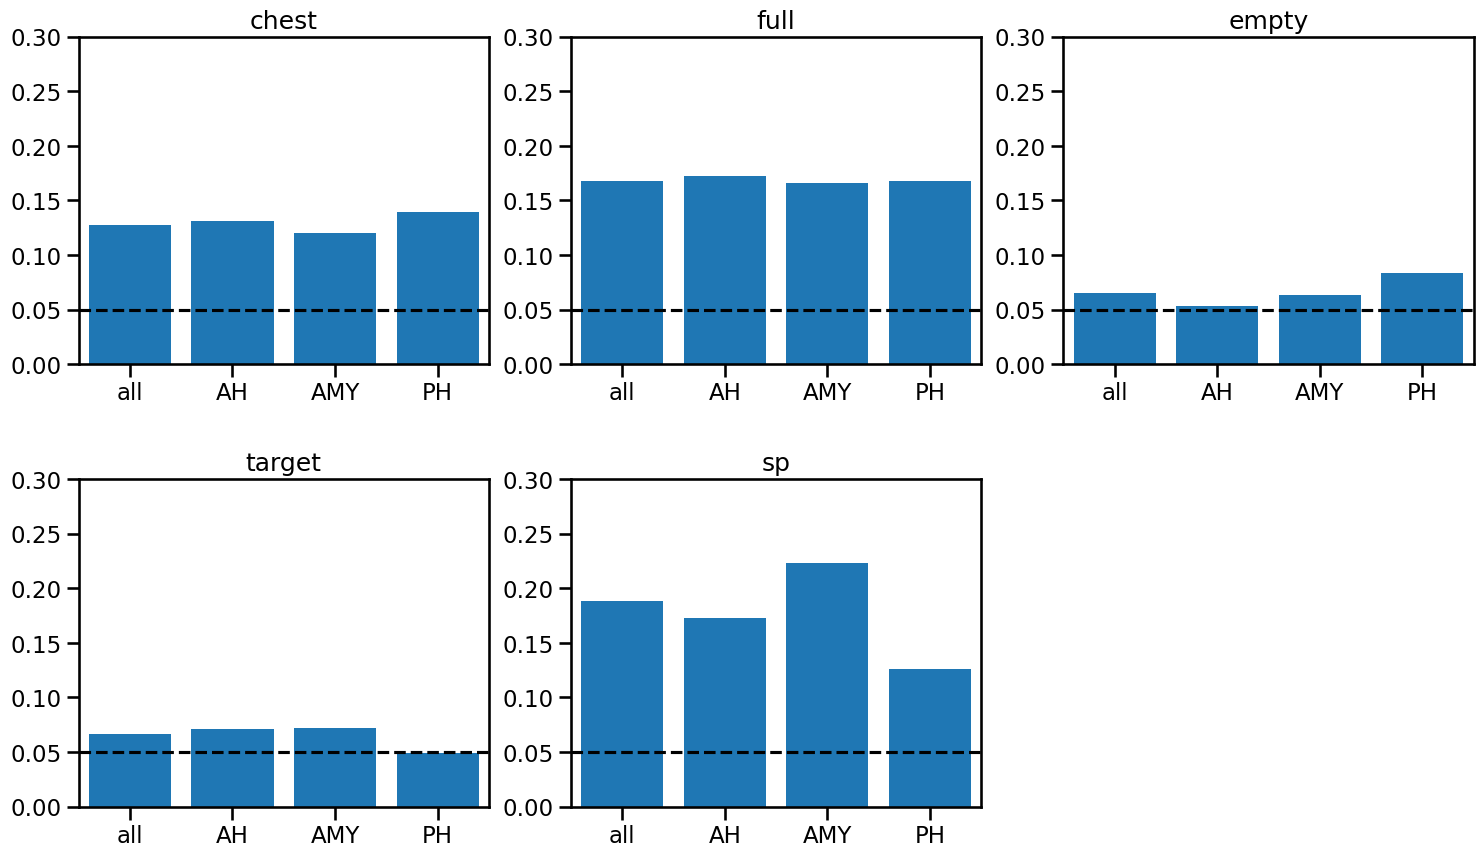

In [46]:
axes = make_axes(len(analyses), 3, hspace=0.35, figsize=(18, 10))
for analysis, ax in zip(analyses, axes):

    out = {}
    out['all'] = results[analysis] / n_units

    for value in places[place]:
        temp = all_results[all_results[place] == value]
        out[value] = sum(temp['is_' + analysis + '_cell']) / len(temp)

    plot_bar(out.values(), out.keys(), title=analysis, ylim=[0, 0.30], ax=ax)
    add_hlines(0.05, linestyle='--', color='black', ax=ax)

## Within Task Overlap

Compute the overlap of labels within TH task

In [47]:
# Compute overlap between labels within TH task
over = np.zeros([len(analysis_columns), len(analysis_columns)])
for i1, acol1 in enumerate(analysis_columns):
    a1res = set(all_results[all_results[acol1]].wvID.values)
    
    for i2, acol2 in enumerate(analysis_columns):
        a2res = set(all_results[all_results[acol2]].wvID.values)
        
        over[i1, i2] = len(a1res.intersection(a2res)) / len(a1res)

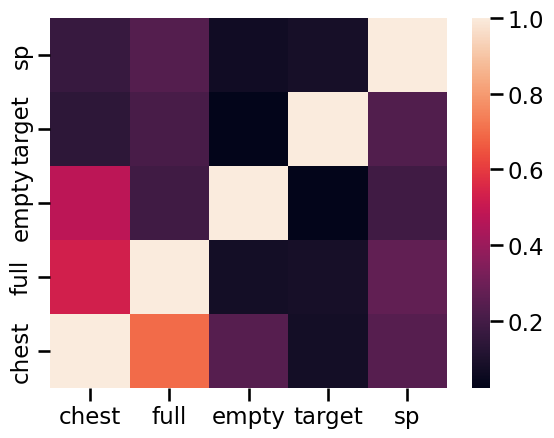

In [48]:
# Plot the overlap between TH labels
ax = sns.heatmap(over, xticklabels=analyses, yticklabels=analyses)
ax.invert_yaxis()

## Distributions

In [49]:
# Plot settings
bins = 35

### Chest Measures

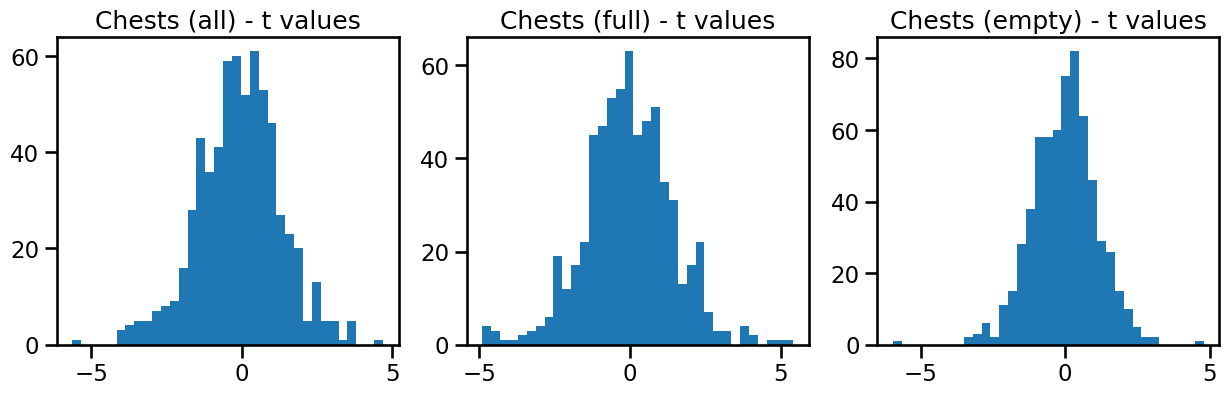

In [50]:
# Plot t-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_t_val_all.values, title='Chests (all) - t values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_t_val_full.values, title='Chests (full) - t values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_t_val_empt.values, title='Chests (empty) - t values', bins=bins, ax=axes[2])

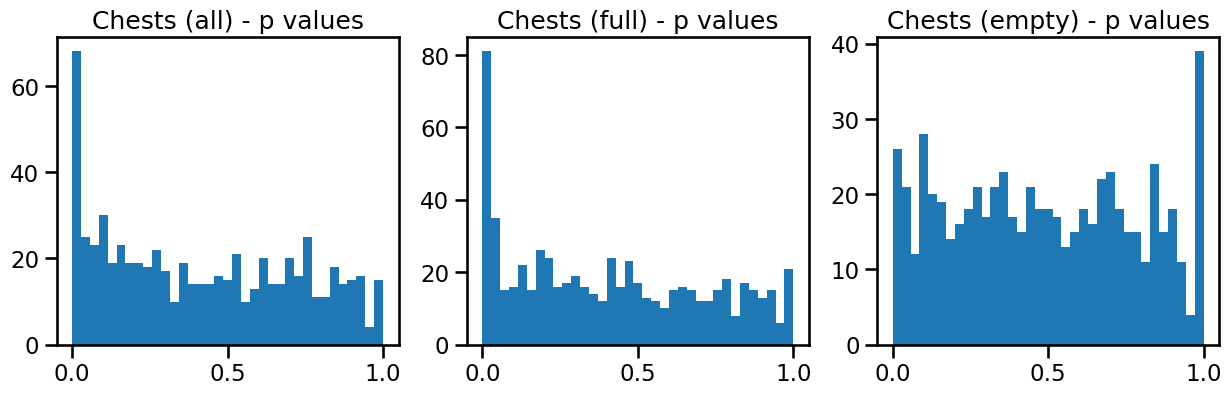

In [51]:
# Plot p-values of the chest measures
axes = make_axes(3, 3, figsize=(15, 4))
plot_hist(all_results.fr_p_val_all.values, title='Chests (all) - p values', bins=bins, ax=axes[0])
plot_hist(all_results.fr_p_val_full.values, title='Chests (full) - p values', bins=bins, ax=axes[1])
plot_hist(all_results.fr_p_val_empt.values, title='Chests (empty) - p values', bins=bins, ax=axes[2])

### Position & Sequence Measures

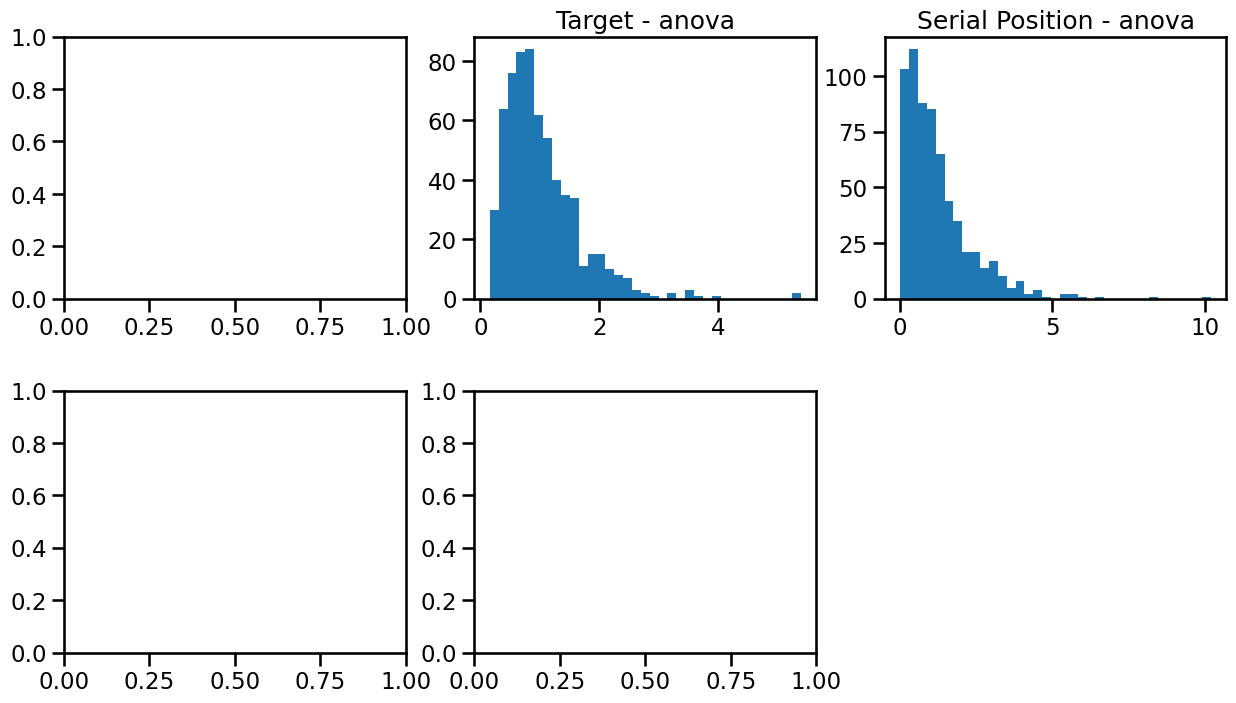

In [52]:
# Plot measure values of the position & sequence measures
axes = make_axes(6, 3, figsize=(15, 8), hspace=0.35)
#plot_hist(all_results.place_anova.values, title='Place - anova', bins=bins, ax=axes[0])
plot_hist(all_results.target_anova.values, title='Target - anova', bins=bins, ax=axes[1])
plot_hist(all_results.serial_anova.values, title='Serial Position - anova', bins=bins, ax=axes[2])
#plot_hist(all_results.place_info.values, title='Place - info', bins=bins, ax=axes[3])
#plot_hist(all_results.target_info.values, title='Target - info', bins=bins, ax=axes[4])
axes[5].set_axis_off()

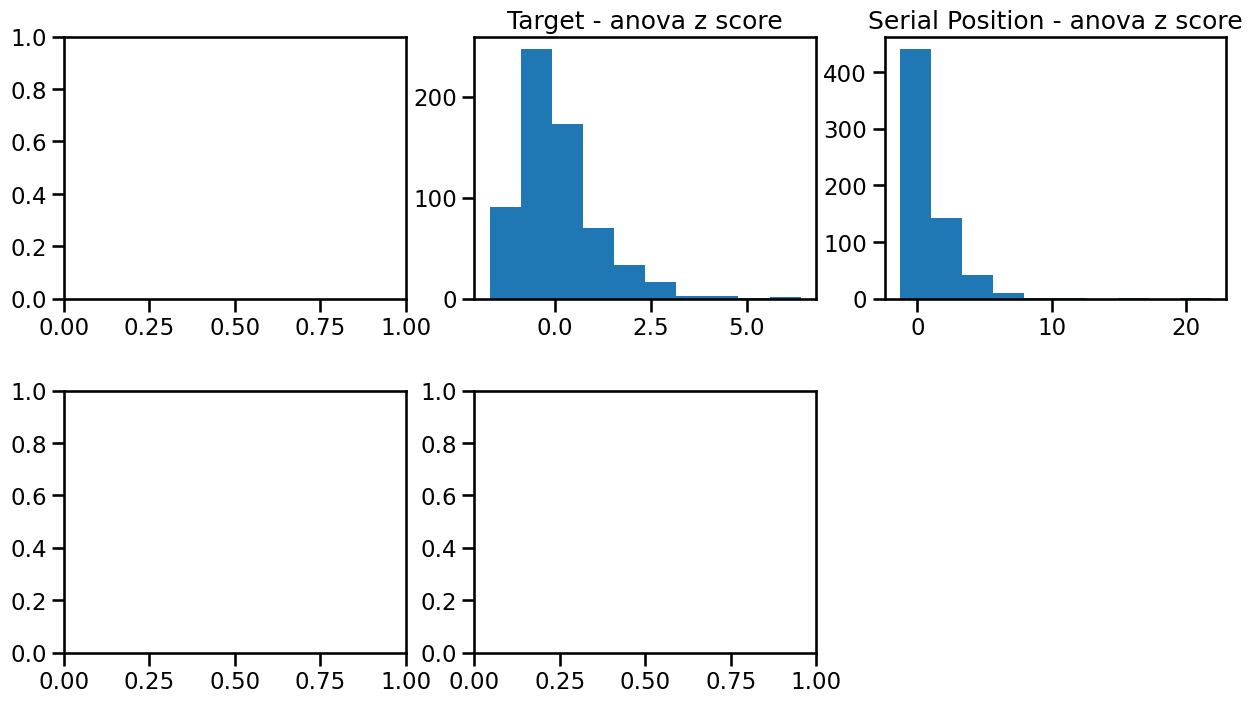

In [53]:
# Plot surrogate z-scores of the position & sequence measures
axes = make_axes(6, 3, figsize=(15, 8), hspace=0.35)
#plot_hist(all_results.place_anova_surr_z_score.values, title='Place - anova z score', ax=axes[0])
plot_hist(all_results.target_anova_surr_z_score.values, title='Target - anova z score', ax=axes[1])
plot_hist(all_results.serial_anova_surr_z_score.values, title='Serial Position - anova z score', ax=axes[2])
#plot_hist(all_results.place_info_surr_z_score.values, title='Place - info z score', ax=axes[3])
#plot_hist(all_results.target_info_surr_z_score.values, title='Target - info z score', ax=axes[4])
axes[5].set_axis_off()

In [54]:
#bins=50

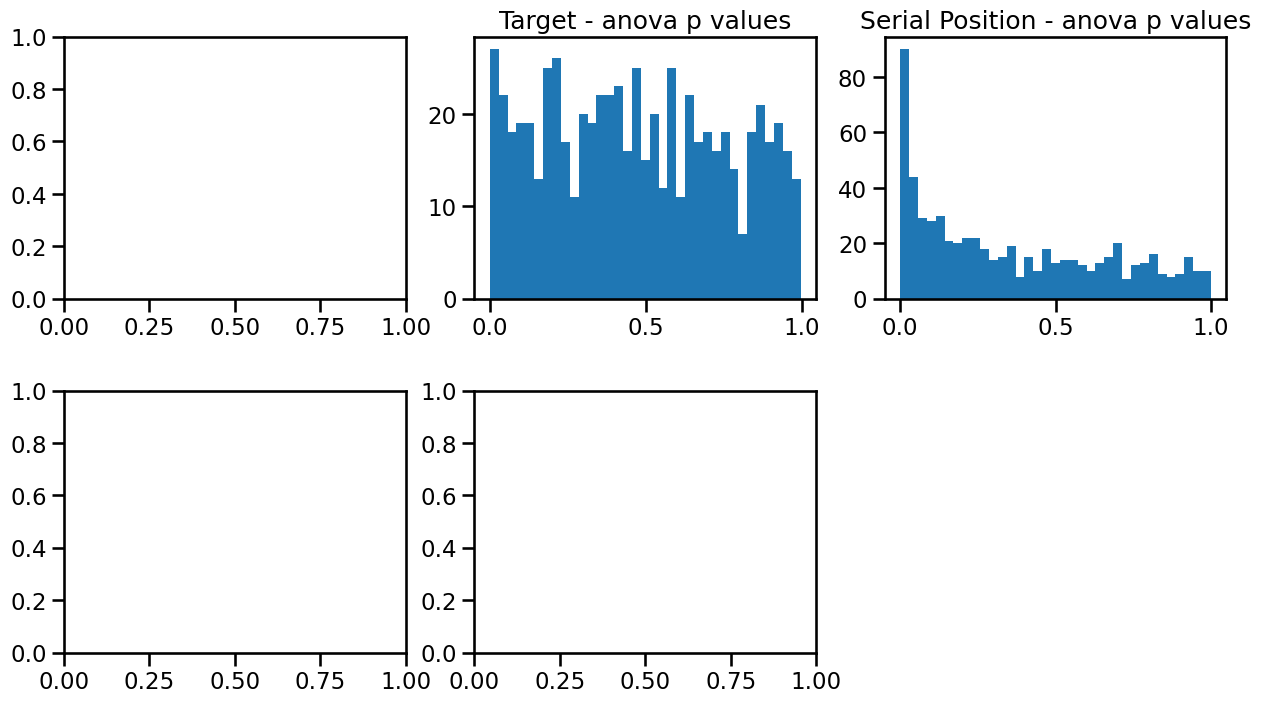

In [55]:
# Plot p values of the position & sequence measures
axes = make_axes(6, 3, figsize=(15, 8), hspace=0.35)
#plot_hist(all_results.place_anova_surr_p_val.values, title='Place - anova p values', bins=bins, ax=axes[0])
plot_hist(all_results.target_anova_surr_p_val.values, title='Target - anova p values', bins=bins, ax=axes[1])
plot_hist(all_results.serial_anova_surr_p_val.values, title='Serial Position - anova p values', bins=bins, ax=axes[2])
#plot_hist(all_results.place_info_surr_p_val.values, title='Place - info p values', bins=bins, ax=axes[3])
#plot_hist(all_results.target_info_surr_p_val.values, title='Target - info p values', bins=bins, ax=axes[4])
axes[5].set_axis_off()

## Task Overlap Analysis

In [56]:
# Define base project path
project_path = '/data12/jacobs_lab/WVTH/'

In [57]:
# Create paths object
paths = Paths(project_path)

### Identity Neuron

Identity neuron fields:
- ID_neuron: identity neuron
- MI_neuron: multiple identity neuron
- SI_neuron: single identity neuron

In [58]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    id_file_name = 'ID neuron CelebA_NavSelect MeanResponse 2SD.mat'
if experiment == 'THO':
    id_file_name = 'ID neuron ImageNet_NavSelect MeanResponse 2SD.mat'

In [59]:
# Load nback results data
nback_data = load_matfile(id_file_name, folder=paths.info / 'nback', squeeze_me=True)

In [60]:
# Check the available keys in the loaded nback data
keys = [key for key in nback_data.keys() if key[0] != '_']
keys

['CodeID', 'CodeIDNum', 'ID_neuron', 'MI_neuron', 'SI_neuron', 'selMethod']

### Baseline firing

In [61]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    file_name = 'SortedFRCelebA_Nav.mat'
if experiment == 'THO':
    file_name = 'SortedFRImageNet_Nav.mat'

In [62]:
# Load the data file
fr_data = load_matfile(file_name, folder=paths.info / 'nback', squeeze_me=True)

In [63]:
# Check the available keys in the metadata file
print([el for el in fr_data.keys() if el[0] != '_'])

['sessions', 'timestampsOfCellAll', 'vCell', 'areaCell', 'vCh', 'vClusterID', 'vWire', 'periodsAll', 'binW', 'binStep', 'FR', 'beh', 'FR_sort', 'vReject', 'vKeep', 'pBase', 'pAnova', 'vAnova', 'vBase']


In [64]:
# Add the baseline response firing analysis to collection of analyses
nback_data['vBase'] = fr_data['vBase']

#### Overlap Within nBack

In [65]:
# Define list of nback analyses
nback_analyses = ['ID_neuron', 'MI_neuron', 'SI_neuron', 'vBase']

In [66]:
# Compute overlap between labels within nBack task
over = np.zeros([len(nback_analyses), len(nback_analyses)])
for i1, acol1 in enumerate(nback_analyses):
    a1res = set(nback_data[acol1])
    
    for i2, acol2 in enumerate(nback_analyses):
        a2res = set(nback_data[acol2])
        
        over[i1, i2] = len(a1res.intersection(a2res)) / len(a1res)

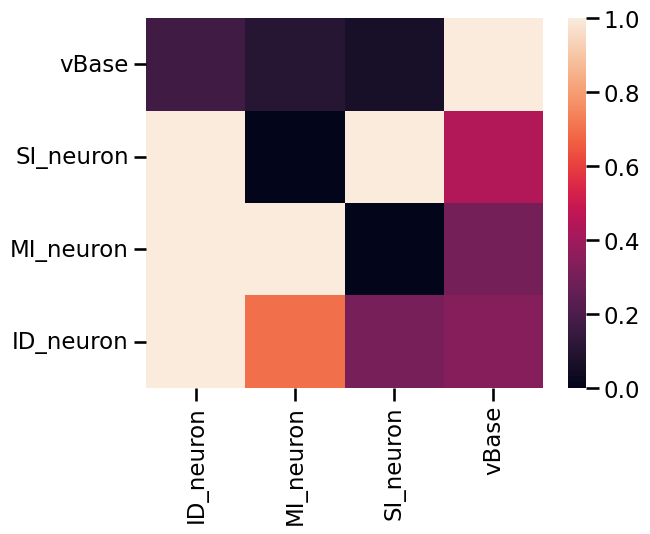

In [67]:
# Plot the overlap between nBack labels
ax = sns.heatmap(over, xticklabels=nback_analyses, yticklabels=nback_analyses)
ax.invert_yaxis()

# Compute Between Task Overlap

In [68]:
# Set which nBack analysis to compare to
nb_analysis = 'base'  # 'base', 'ID'

In [69]:
if nb_analysis == 'ID':
    nb_data = nback_data['ID_neuron']
    #nb_data = nback_data['SI_neuron']
if nb_analysis == 'base':
    nb_data = nback_data['vBase']

In [70]:
print(experiment, ' - ', nb_analysis, '\n')
print('\t {} \t {} \t {} \t {} \t\t {} \t\t{}'.format('#NB', '#TH', '#Over', '%Over', 'pval', 'exp'))
for analysis in analyses:

    th_data = all_results[all_results['is_' + analysis + '_cell']].wvID.values
    n_th = len(th_data)

    n_nb = len(nb_data)
    
    inter = len(set(th_data).intersection(set(nb_data)))
    
    arr = np.array([[inter, n_th-inter],
                    [n_nb-inter, n_units-n_th-n_nb+inter]])
    tstat, pval, dof, exp = chi2_contingency(arr, False)

    print('{} \t {} \t {} \t {} \t {:5.2f}% \t {:5.4f} \t {:2d}'.format(\
        analysis, n_nb, n_th, inter, (inter / n_nb) * 100, pval, round(exp[0][0])))

THF  -  base 

	 #NB 	 #TH 	 #Over 	 %Over 		 pval 		exp
chest 	 106 	 82 	 26 	 24.53% 	 0.0001 	 14
full 	 106 	 108 	 31 	 29.25% 	 0.0002 	 18
empty 	 106 	 42 	 9 	  8.49% 	 0.3718 	  7
target 	 106 	 43 	 8 	  7.55% 	 0.6982 	  7
sp 	 106 	 121 	 22 	 20.75% 	 0.5767 	 20


## Combine Between Tasks

In [71]:
# Check that all the IDs line up
for nb_analysis in ['ID_neuron', 'vBase']:
    for wvid in nback_data[nb_analysis]:
        if wvid not in all_results.wvID.values:
            assert wvid in all_results.wvID.values

In [72]:
# Add columns to overall dataframe for nback task labels
all_results['is_ID_cell'] = False
all_results['is_baseline_cell'] = False

In [73]:
# Add in results from nback analyses listing which cells are nback task active cells
for wvid in all_results.wvID.values:
    if wvid in nback_data['ID_neuron']:
        all_results.loc[all_results[all_results.wvID == wvid].index[0], 'is_ID_cell'] = True
    if wvid in nback_data['vBase']:
        all_results.loc[all_results[all_results.wvID == wvid].index[0], 'is_baseline_cell'] = True

In [74]:
# Check that the alignment worked
assert set(nback_data['vBase']) == set(all_results[all_results.is_baseline_cell].wvID.values)
assert set(nback_data['ID_neuron']) == set(all_results[all_results.is_ID_cell].wvID.values)

#### Check the distribution of cells in nBack

In [75]:
# Define nback label columns to add
nback_analysis_columns = ['is_ID_cell', 'is_baseline_cell']

In [76]:
# Check the number of detected cells per session
pd.pivot_table(all_results, nback_analysis_columns, index=['subject_id', 'session_id'], aggfunc=np.sum)

is_ID_cell  is_baseline_cell
subject_id session_id                                       
wv001      THF_wv001_session_0          11                15
           THF_wv001_session_2           5                17
           THF_wv001_session_3           9                12
           THF_wv001_session_4           1                 9
wv002      THF_wv002_session_0           3                 9
           THF_wv002_session_1           4                 6
wv003      THF_wv003_session_0           0                 0
wv004      THF_wv004_session_0          11                18
           THF_wv004_session_1           8                13
wv005      THF_wv005_session_0           1                 7

In [77]:
# # Example: make a new column for overlap cells
# all_results['sp_base_overlap'] = all_results['is_sp_cell'] & all_results['is_baseline_cell']

In [78]:
# # Save out the combined results file
# all_results.to_csv(experiment + '_combined_all_results.csv')

## Overlap Stats

In [79]:
# Define the file path for the relevant nback results file
if experiment == 'THF':
    stats_filename = 'vID_vBase_Selection_CelebA_Nav.csv'
if experiment == 'THO':
    stats_filename = 'vID_vBase_Selection_ImageNet_Nav.csv'

In [80]:
# Load n-back stats
nback_stats = pd.read_csv(paths.info / 'nback' / stats_filename)

In [81]:
# Rename the CellIndex column -> WvID
new_names = {'CellIndex' : 'wvID', 'Fvalue-anova' : 'id_fvalue', 'TValue-baseline' : 'baseline_tvalue', 
             'IDNeuron' : 'is_id', 'vBaseline' : 'is_baseline'}
nback_stats.rename(columns=new_names, inplace=True)

In [82]:
# Sub-select only stats columns
nback_stats = nback_stats[['wvID', 'id_fvalue', 'baseline_tvalue', 'is_id', 'is_baseline']]

In [83]:
# Settings
cmap = 'magma_r'

In [84]:
# Create merged df
merged = all_results.merge(nback_stats)

In [85]:
# 
merged['baseline_tvalue_abs'] = np.abs(merged['baseline_tvalue'])
merged['fr_t_val_full_abs'] = np.abs(merged['fr_t_val_full'])

In [86]:
yy = merged[['id_fvalue', 'baseline_tvalue', 'fr_t_val_full', 'is_id', 'is_baseline']]
#yy.corr('spearman')
#pd.plotting.scatter_matrix(yy);

In [87]:
merged[['baseline_tvalue', 'serial_anova']].corr('spearman')

,baseline_tvalue,serial_anova
baseline_tvalue,1.000000,0.000519
serial_anova,0.000519,1.000000


In [88]:
spearmanr(merged['baseline_tvalue'], merged['serial_anova'])

SpearmanrResult(correlation=0.0005192762050741034, pvalue=0.9895145844867169)

In [89]:
merged[['baseline_tvalue_abs', 'fr_t_val_full_abs']].corr('spearman')

,baseline_tvalue_abs,fr_t_val_full_abs
baseline_tvalue_abs,1.000000,0.101915
fr_t_val_full_abs,0.101915,1.000000


In [90]:
merged[['baseline_tvalue', 'fr_t_val_full']].corr('spearman')

,baseline_tvalue,fr_t_val_full
baseline_tvalue,1.00000,-0.28851
fr_t_val_full,-0.28851,1.00000


In [91]:
merged[['baseline_tvalue', 'serial_anova']].corr('spearman')

,baseline_tvalue,serial_anova
baseline_tvalue,1.000000,0.000519
serial_anova,0.000519,1.000000


In [92]:
merged[['baseline_tvalue_abs', 'serial_anova']].corr('spearman')

,baseline_tvalue_abs,serial_anova
baseline_tvalue_abs,1.00000,0.03787
serial_anova,0.03787,1.00000


<AxesSubplot:xlabel='baseline_tvalue', ylabel='serial_anova'>

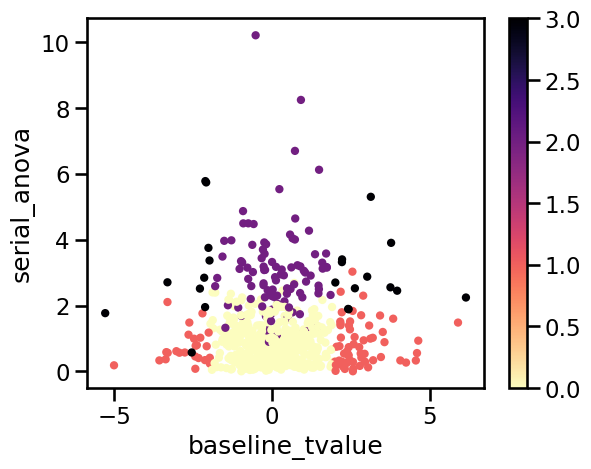

In [93]:
tcs = merged['is_sp_cell'].astype(int) * 2 + merged['is_baseline']
merged.plot.scatter('baseline_tvalue', 'serial_anova', c=tcs, cmap=cmap)

<AxesSubplot:xlabel='baseline_tvalue_abs', ylabel='serial_anova'>

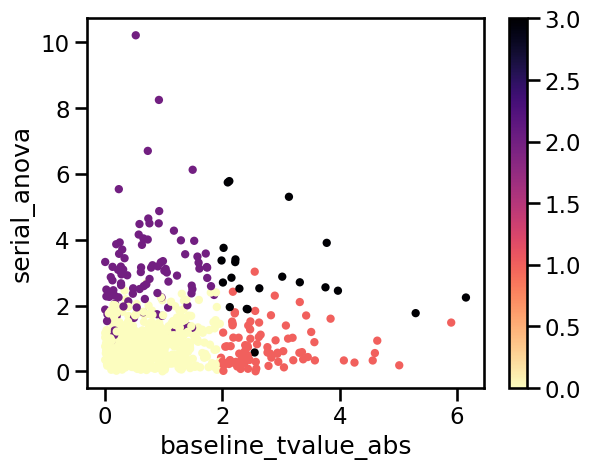

In [94]:
tcs = merged['is_sp_cell'].astype(int) * 2 + merged['is_baseline']
merged.plot.scatter('baseline_tvalue_abs', 'serial_anova', c=tcs, cmap=cmap)

(0.0, 6.0)

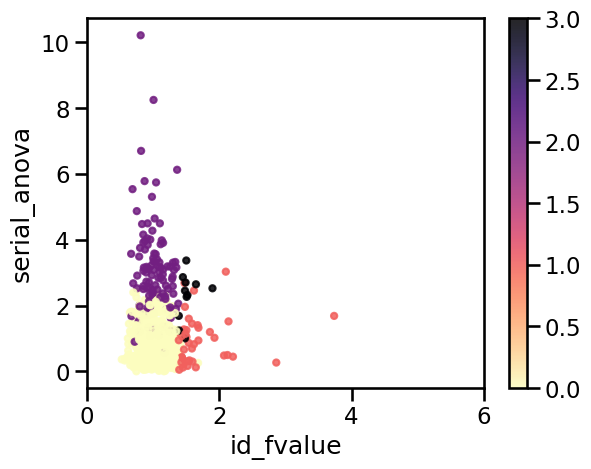

In [95]:
tcs = merged['is_sp_cell'].astype(int) * 2 + merged['is_id']
merged.plot.scatter('id_fvalue', 'serial_anova', c=tcs, cmap=cmap, alpha=0.85)
plt.xlim([0, 6])

<AxesSubplot:xlabel='baseline_tvalue', ylabel='fr_t_val_full'>

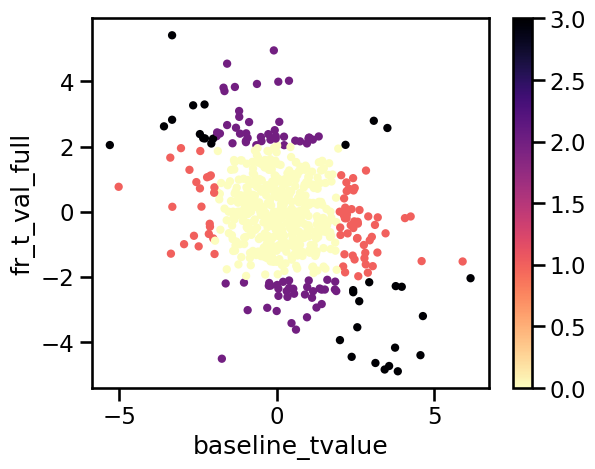

In [96]:
tcs = merged['is_full_cell'] * 2 + merged['is_baseline']
merged.plot.scatter('baseline_tvalue', 'fr_t_val_full', c=tcs, cmap=cmap)

<AxesSubplot:xlabel='baseline_tvalue_abs', ylabel='fr_t_val_full_abs'>

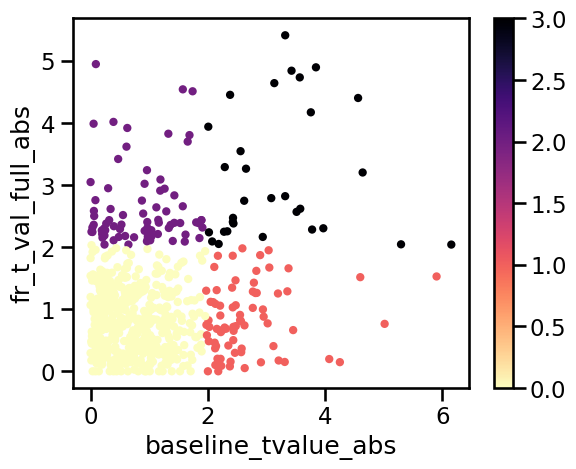

In [97]:
merged.plot.scatter('baseline_tvalue_abs', 'fr_t_val_full_abs', c=tcs, cmap=cmap)

(0.0, 4.0)

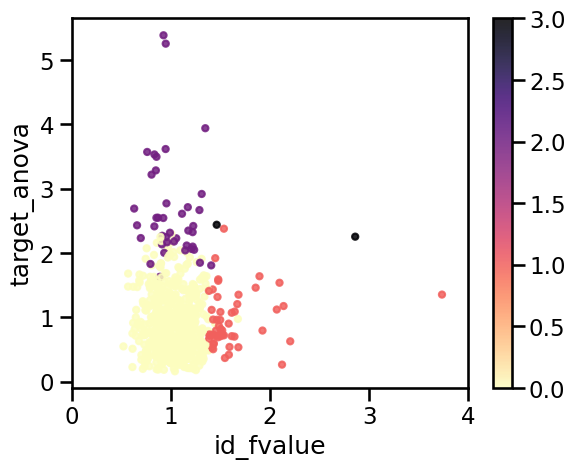

In [98]:
tcs = merged['is_target_cell'] * 2 + merged['is_id']
merged.plot.scatter('id_fvalue', 'target_anova', c=tcs, cmap=cmap, alpha=0.85)
plt.xlim([0, 4])

(0.0, 4.0)

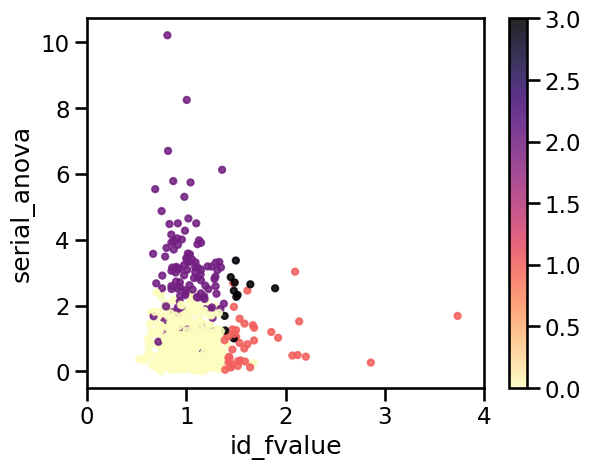

In [99]:
tcs = merged['is_sp_cell'] * 2 + merged['is_id']
merged.plot.scatter('id_fvalue', 'serial_anova', c=tcs, cmap=cmap, alpha=0.85)
plt.xlim([0, 4])

<AxesSubplot:xlabel='baseline_tvalue_abs', ylabel='target_anova'>

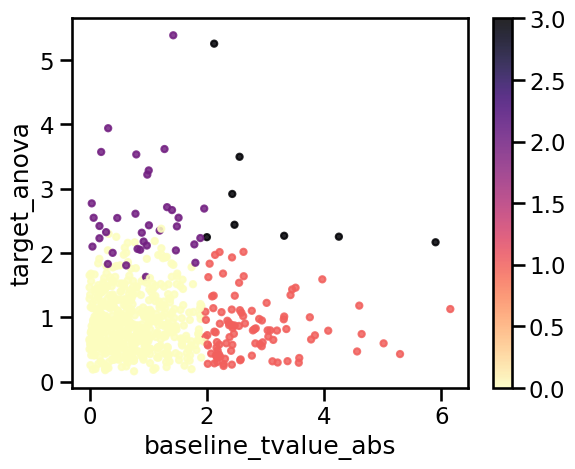

In [100]:
tcs = merged['is_target_cell'] * 2 + merged['is_baseline']
merged.plot.scatter('baseline_tvalue_abs', 'target_anova', c=tcs, cmap=cmap, alpha=0.85)